# Cannabis Grow Segmentation with TorchGeo (torchgeo-compatible version)

This script refactors the dataset and dataloaders to use torchgeo's GeoDataset and RandomGeoSampler.

In [110]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchgeo.datasets import GeoDataset
from torchgeo.samplers import RandomGeoSampler
from torchgeo.transforms import AugmentationSequential
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple
import rasterio
from rasterio.features import rasterize
from shapely.geometry import shape, box
import albumentations as A
from albumentations.pytorch import ToTensorV2
from rasterio.crs import CRS
from rasterio.transform import xy
from shapely.geometry import Polygon

In [111]:
# ────────── Cell: Fix CannabisSegmentationGeoDataset ──────────

from pathlib import Path
import json
import numpy as np
import rasterio
from rasterio.transform import xy
from rasterio.features import rasterize
from shapely.geometry import Polygon
from torchgeo.datasets import RasterDataset
from rtree import index as rindex
import re
from datetime import datetime


class CannabisSegmentationGeoDataset(RasterDataset):
    def __init__(self, annotations_dir, naip_root, transforms=None):
        self.annotation_paths = sorted(Path(annotations_dir).glob("*.json"))
        self.naip_root = Path(naip_root)
        self.filename_glob = "*_*.tif"
        self.filename_regex = r"^.*_(?P<date>\d{8})"
        self.date_format = "%Y%m%d"
        self.is_image = True
        self.separate_files = False
        self.all_bands = ("R", "G", "B", "NIR")
        self.rgb_bands = ("R", "G", "B",)
        self.transforms = transforms

        # Build a mapping from ann_path → image_path
        self.image_paths = {}
        for ann_path in self.annotation_paths:
            ann = json.load(open(ann_path))
            self.image_paths[ann_path] = self.naip_root / ann["imagePath"]

        super().__init__(paths=self.image_paths.values(), transforms=transforms)

        # 1) compute new_bounds
        self._bounds = []
        for ann_path, img_path in self.image_paths.items():
            with rasterio.open(img_path) as src:
                self._crs = src.crs
                b = src.bounds
                self._bounds.append((b.left, b.bottom, b.right, b.top))

        # 2) rebuild index by hand
        self.index = rindex.Index()
        for i, b in enumerate(self._bounds):
            self.index.insert(i, b)

        # 3) set the dates
        dates = []
        for fname in self.image_paths.values():
            match = re.match(r"^.*_(\d{8})", fname.name)
            if match:
                date = datetime.strptime(match.group(1), "%Y%m%d")
                dates.append(date.timestamp())
        if dates:
            self.mint = min(dates)
            self.maxt = max(dates)
        else:
            self.mint = 0
            self.maxt = 9223372036854775807

    def __len__(self):
        return len(self.annotation_paths)

    def __getitem__(self, query):
        # 1) Open the correct tile & read the window
        bbox = query["bbox"]
        ann_path = self._get_path_for_bounds(bbox)  # GeoDataset helper
        img_path = self.image_paths[ann_path]

        with rasterio.open(img_path) as src:
            window = src.window(*bbox)
            image = src.read(window=window)
            height, width = image.shape[1], image.shape[2]
            win_transform = src.window_transform(window)

        annotation = json.load(open(ann_path))

        # 2) Initialize mask & poly
        mask = np.zeros((height, width), dtype=np.uint8)
        poly = None

        # 3) Rasterize all shapes into mask
        for shape in annotation["shapes"]:
            if shape["label"] != "cannabis - old":
                continue
            p = labelme_points_to_geopolygon(shape["points"], src.transform)
            single = rasterize(
                [(p, 1)],
                out_shape=(height, width),
                transform=win_transform,
                fill=0,
                all_touched=True,
                dtype=np.uint8
            )
            mask = np.maximum(mask, single)
            poly = p

        # 4) Apply transforms (if any)
        if self.transforms:
            out = self.transforms(image=image, mask=mask)
            image, mask = out["image"], out["mask"]

        # 5) Build return dict
        sample = {"image": image, "mask": mask}
        if poly is not None:
            sample["polygon"] = poly
        return sample

# ────────── End Cell ──────────

Window bounds: (np.float64(719135.4810257332), np.float64(4250382.810034573), np.float64(719442.681025733), np.float64(4250690.010034572))
Polygon bounds: (719194.8133640554, 4250542.847465438, 719224.2142857143, 4250583.4926267285)
Do they intersect? True
Image shape (bands, height, width): (4, 285, 128)
Rasterizing to shape: (285, 128)
Single shape max: 1
Mask max: 1


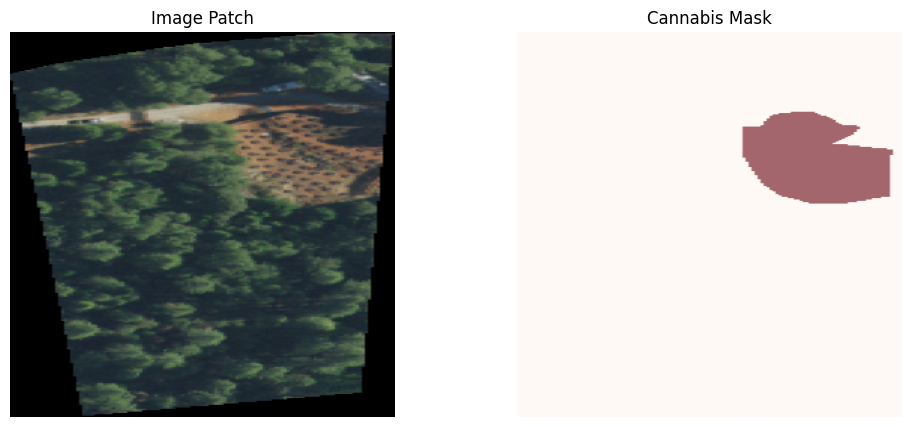

In [112]:
# ────────── Sample one patch manually ──────────

import json, numpy as np, rasterio, matplotlib.pyplot as plt
from rasterio.transform import xy
from rasterio.features import rasterize
from shapely.geometry import Polygon

# 1) tranformation for labelme images to a coordinate reference system
def labelme_points_to_geopolygon(points, transform):
    return Polygon([xy(transform, y, x) for x, y in points])

# 2) Instantiate dataset (make sure you've run the fixed class definition)
dataset = CannabisSegmentationGeoDataset(
    annotations_dir="../cannabis-parcels/cannabis-parcels-masked",
    naip_root="../cannabis-parcels/cannabis-parcels-masked",
    transforms=None
)

# 3) Grab the first annotation file + JSON
ann_path = dataset.annotation_paths[1]
ann = json.load(open(ann_path))
img_path = dataset.image_paths[ann_path]

# 4) Open the NAIP tile and get the first "cannabis" polygon
with rasterio.open(img_path) as src:
    image = src.read()
    win_t = src.transform

# 5) Rasterize the mask for all cannabis shapes in that window
_, h, w = image.shape
mask = np.zeros((h, w), dtype=np.uint8)
for shape in ann["shapes"]:
    if shape["label"] != "cannabis - old":
        p = labelme_points_to_geopolygon(shape["points"], src.transform)

        # Print info to debug
        window_bounds = rasterio.windows.bounds(window, src.transform)
        print("Window bounds:", window_bounds)
        print("Polygon bounds:", p.bounds)
        print("Do they intersect?", p.intersects(box(*window_bounds)))

        # Clip the polygon to the window
        p_window = p.intersection(box(*window_bounds))

        print("Image shape (bands, height, width):", image.shape)
        print("Rasterizing to shape:", (h, w))

        # Proceed only if there's something to rasterize
        if not p_window.is_empty:
            single = rasterize(
                [(p_window, 1)],
                out_shape=(h, w),
                transform=win_t,
                all_touched=True,
                dtype=np.uint8
            )
            print("Single shape max:", np.max(single))
            mask = np.maximum(mask, single)
            print("Mask max:", np.max(mask))
        else:
            print("Polygon is empty after intersection")

# 6) Plot
if image.ndim == 3 and image.shape[0] in [3, 4]:
    image = np.transpose(image, (1, 2, 0))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[..., :3], extent=src.bounds)
plt.title("Image Patch")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="Reds", alpha=0.6, extent=src.bounds)
plt.title("Cannabis Mask")
plt.axis("off")
plt.show()

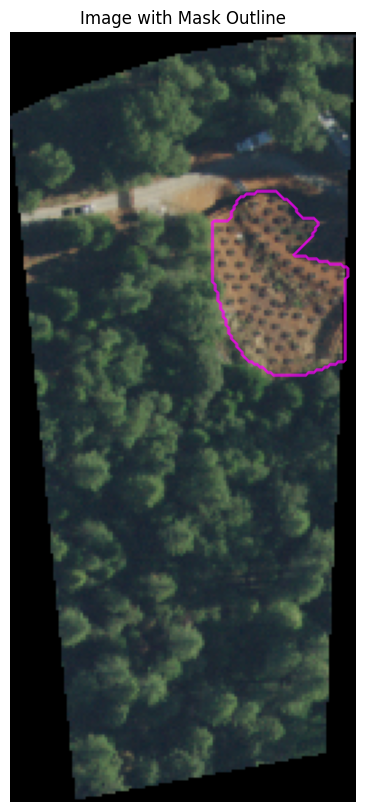

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# image: shape (H, W, C), mask: shape (H, W)
# If image is CHW, convert to HWC for plotting
if image.shape[0] in [3, 4] and image.shape[0] < image.shape[1]:
    image = np.transpose(image, (1, 2, 0))

plt.figure(figsize=(10, 10))
plt.imshow(image[..., :3])  # Show only RGB channels if image has 4 channels
plt.contour(mask, colors='#FF00FF', linewidths=1, alpha=0.3)  # Outline mask in bright purple, adjust linewidth as needed
plt.title("Image with Mask Outline")
plt.axis("off")
plt.show()

In [109]:
import json, random, rasterio
from rasterio.transform import xy
from shapely.geometry import Polygon, box
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset

def labelme_points_to_geopolygon(points, transform):
    return Polygon([xy(transform, y, x) for x, y in points])

class PositiveNegativeGeoSampler(RasterDataset):
    def __init__(self, dataset, size, length, pos_fraction=0.5):
        # 1) Extract & fix the 2D ROI from the existing rtree index
        b = tuple(dataset.index.bounds)
        if len(b) != 4:
            raise RuntimeError(f"Expected 4‑tuple bounds, got {len(b)}")
        minx, miny, maxx, maxy = b
        if minx > maxx: minx, maxx = maxx, minx
        if miny > maxy: miny, maxy = maxy, miny
        roi = (minx, miny, maxx, maxy)
        super().__init__(dataset, roi)

        self.ds = dataset
        self.size = size
        self.length = length
        self.pos_frac = pos_fraction
        self.pos_bboxes = []
        self.neg_bboxes = []

        # 2) Precompute positive & negative bboxes
        for ann_path in self.ds.annotation_paths:
            ann = json.load(open(ann_path))
            img_path = self.ds.image_paths[ann_path]
            with rasterio.open(img_path) as src:
                rx, ry = src.res
                half_w = size/2 * rx
                half_h = size/2 * abs(ry)

                polys = []
                # positives: centroids of each cannabis poly
                for shape in ann["shapes"]:
                    if shape["label"] != "cannabis":
                        continue
                    poly = labelme_points_to_geopolygon(shape["points"], src.transform)
                    polys.append(poly)
                    cx, cy = poly.centroid.x, poly.centroid.y
                    self.pos_bboxes.append((cx-half_w, cy-half_h, cx+half_w, cy+half_h))

                # negatives: random patches avoiding any poly
                w, h = src.width, src.height
                for _ in range(max(1, len(polys)*2)):
                    for __ in range(50):
                        ix, iy = random.randint(0, w-1), random.randint(0, h-1)
                        cx2, cy2 = xy(src.transform, iy, ix)
                        nb = (cx2-half_w, cy2-half_h, cx2+half_w, cy2+half_h)
                        if not any(p.intersects(box(*nb)) for p in polys):
                            self.neg_bboxes.append(nb)
                            break

    def __iter__(self):
        for _ in range(self.length):
            if random.random() < self.pos_frac and self.pos_bboxes:
                yield {"bbox": random.choice(self.pos_bboxes)}
            else:
                yield {"bbox": random.choice(self.neg_bboxes)}

    def __len__(self):
        return self.length

# ─── Usage ───
patch_size = 512
sampler = PositiveNegativeGeoSampler(dataset, size=patch_size,
                                     length=1000, pos_fraction=0.5)
loader = DataLoader(dataset, batch_size=4, sampler=sampler)

# Visualize one batch
batch = next(iter(loader))
imgs, msks = batch["image"], batch["mask"]

import matplotlib.pyplot as plt
import numpy as np

for i in range(len(imgs)):
    img = imgs[i].cpu().numpy()
    if img.ndim==3 and img.shape[0] in [3,4]:
        img = np.transpose(img, (1,2,0))
    msk = msks[i].cpu().numpy()
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img[..., :3]); plt.title("Image"); plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(msk, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.show()

TypeError: 'int' object is not subscriptable

## Data Augmentation

In [ ]:
def get_transforms():
    train_transform = A.Compose([
        A.RandomCrop(512, 512),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    val_transform = A.Compose([
        A.CenterCrop(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    return train_transform, val_transform

In [ ]:
## U-Net Model Architecture (unchanged)

import torch.nn.functional as F
import torchvision.models as models

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class UNetWithResNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=1, pretrained=True):
        super().__init__()
        resnet = models.resnet50(weights='IMAGENET1K_V2' if pretrained else None)
        # Modify first conv layer to accept 4 channels
        w = resnet.conv1.weight
        resnet.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if n_channels == 4:
            resnet.conv1.weight.data[:, :3, :, :] = w.data
            resnet.conv1.weight.data[:, 3:, :, :].zero_()
        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4
        self.center = nn.Sequential(
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True)
        )
        self.decoder4 = DecoderBlock(2048, 1024, 1024)
        self.decoder3 = DecoderBlock(1024, 512, 512)
        self.decoder2 = DecoderBlock(512, 256, 256)
        self.decoder1 = DecoderBlock(256, 64, 64)
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, n_classes, kernel_size=1),
            nn.Sigmoid()
        )
        self.final_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    def forward(self, x):
        input_size = x.size()[2:]
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        e0 = x
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e4 = self.center(e4)
        d4 = self.decoder4(e4, e3)
        d3 = self.decoder3(d4, e2)
        d2 = self.decoder2(d3, e1)
        d1 = self.decoder1(d2, e0)
        out = self.final_conv(d1)
        out = self.final_up(out)
        if out.size()[2:] != input_size:
            out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
        return out

In [ ]:
## Training Loop (unchanged)

from torch.utils.data import DataLoader

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler._LRScheduler,
    num_epochs: int,
    device: torch.device
) -> Tuple[List[float], List[float]]:
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0
        for batch_idx, batch in enumerate(train_loader):
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)
            if batch_idx == 0 and epoch == 0:
                print(f"\nInput shapes:")
                print(f"Images: {images.shape}")
                print(f"Masks: {masks.shape}")
            optimizer.zero_grad()
            outputs = model(images)
            if batch_idx == 0 and epoch == 0:
                print(f"Outputs: {outputs.shape}\n")
                assert outputs.shape == masks.shape, \
                    f"Shape mismatch: outputs {outputs.shape} vs masks {masks.shape}"
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1
        train_loss = epoch_loss / batch_count
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        val_count = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["image"].to(device)
                masks = batch["mask"].to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_count += 1
        val_loss = val_loss / val_count
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 40)
    return train_losses, val_losses

## Main Training Script

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    naip_root = "../NAIP_2016"
    annotations_dir = "../cannabis-parcels/cannabis-parcels-masked"
    train_transform, val_transform = get_transforms()
    train_dataset = CannabisSegmentationGeoDataset(
        naip_root=naip_root,
        annotations_dir=annotations_dir,
        transform=train_transform
    )
    val_dataset = CannabisSegmentationGeoDataset(
        naip_root=naip_root,
        annotations_dir=annotations_dir,
        transform=val_transform
    )
    # Use RandomGeoSampler
    patch_size = 512  # or whatever your crop size is
    train_sampler = RandomGeoSampler(train_dataset, size=patch_size, length=25)  # adjust length as needed
    val_sampler = RandomGeoSampler(val_dataset, size=patch_size, length=11)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, sampler=val_sampler)
    # Model, loss, optimizer (use new UNetWithResNet)
    model = UNetWithResNet(n_channels=4, n_classes=1, pretrained=True).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=50,
        device=device
    )
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    torch.save(model.state_dict(), "cannabis_segmentation_model.pth")

In [ ]:
if __name__ == "__main__":
    main()